In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pyspark.sql.functions import col,isnan, when, count
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.functions import udf
from scipy.spatial import distance

import pyspark.sql.functions as F


import pyspark

from pyspark.sql.types import FloatType
from pyspark.sql.types import BooleanType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.functions import regexp_replace
from pyspark.sql import SQLContext

from pyspark.ml.clustering import KMeans



In [3]:
sc = pyspark.SparkContext()

In [4]:
spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

#data = spark.read.option("header",True).option('inferSchema', True).csv("Google-Playstore.csv", sep =',')


In [5]:
data = spark.read.option("header",True).option('inferSchema', True).json("cleaned_v3.json")

In [6]:
data.printSchema()

root
 |-- Ad Supported: boolean (nullable = true)
 |-- Age: long (nullable = true)
 |-- App Id: string (nullable = true)
 |-- App Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Developer Id: string (nullable = true)
 |-- Editors Choice: boolean (nullable = true)
 |-- In App Purchases: boolean (nullable = true)
 |-- Installs: double (nullable = true)
 |-- Installs_stdev_from_Category: double (nullable = true)
 |-- Minimum Android: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- Price_stdev_from_Category: double (nullable = true)
 |-- Quarter of Release: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Rating_Reviews_Ratio: double (nullable = true)
 |-- Rating_stdev_from_Category: double (nullable = true)
 |-- Reviews_Installs_Ratio: double (nullable = true)
 |-- Size: string (nullable = true)
 |-- Size_stdev_from_Category: double (nullable = true)
 |-- Year of Last Update: string (nullable = true)
 |-- Year of Release: s

In [7]:
data = data.withColumn("Year of Last Update", data["Year of Last Update"].cast(IntegerType()).alias("Year of Last Update"))
data = data.withColumn("Year of Release", data["Year of Release"].cast(IntegerType()).alias("Year of Release"))
data = data.withColumn("Size", data["Size"].cast(FloatType()).alias("Size"))
for col in data.columns:
    newcol = '_'.join(col.split(' '))
    data = data.withColumnRenamed(col, newcol) 



In [8]:
data.dtypes

[('Ad_Supported', 'boolean'),
 ('Age', 'bigint'),
 ('App_Id', 'string'),
 ('App_Name', 'string'),
 ('Category', 'string'),
 ('Developer_Id', 'string'),
 ('Editors_Choice', 'boolean'),
 ('In_App_Purchases', 'boolean'),
 ('Installs', 'double'),
 ('Installs_stdev_from_Category', 'double'),
 ('Minimum_Android', 'double'),
 ('Price', 'double'),
 ('Price_stdev_from_Category', 'double'),
 ('Quarter_of_Release', 'string'),
 ('Rating', 'double'),
 ('Rating_Reviews_Ratio', 'double'),
 ('Rating_stdev_from_Category', 'double'),
 ('Reviews_Installs_Ratio', 'double'),
 ('Size', 'float'),
 ('Size_stdev_from_Category', 'double'),
 ('Year_of_Last_Update', 'int'),
 ('Year_of_Release', 'int'),
 ('nReviews', 'double'),
 ('nReviews_stdev_from_Category', 'double')]

In [9]:
features_cluster = ["Reviews_Installs_Ratio", "Size", "Rating", "Price"]



In [10]:
features_other = ["Ad_Supported", "Category", "Developer_Id", "Editors_Choice", "In_App_Purchases",
                       "Minimum_Android", "Year_of_Release", "Year_of_Last_Update"]
features_numeric = ["Rating", "Installs", "nReviews"]

In [11]:
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=features_cluster, outputCol='features_cluster')

assembled_data=assemble.transform(data)


In [12]:
from pyspark.ml.feature import MinMaxScaler

scale=MinMaxScaler(inputCol='features_cluster',outputCol='standardized')

data_scale=scale.fit(assembled_data)

data_scale_output=data_scale.transform(assembled_data)
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator


In [ ]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', 
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    gmm = GaussianMixture(featuresCol='standardized', k=i)
    
    gmm = gmm.fit(data_scale_output)
    
    output=gmm.transform(data_scale_output)
    

    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Text(0, 0.5, 'silhouette')

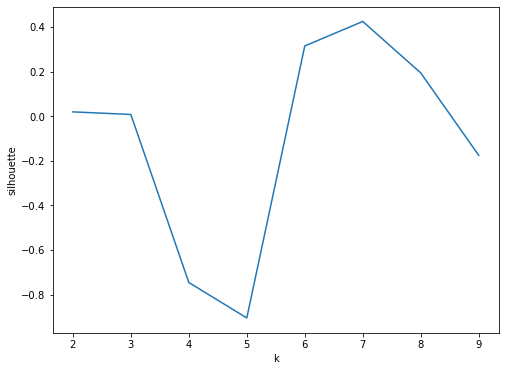

In [15]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('silhouette')

## GMM

In [14]:
gmm = GaussianMixture(featuresCol='standardized', k=7, seed=42)
    
gmm = gmm.fit(data_scale_output)
    
output= gmm.transform(data_scale_output)

In [15]:
dist_clusters = output.select("prediction").distinct().rdd.map(lambda x: x[0]).collect()
dd = {}
for j in dist_clusters:
    dd[j] = output.filter(output["prediction"] == j).select(features_cluster+features_other+features_numeric)

In [16]:
def basic_statistics(df):
    for i in df.dtypes:
        if(i[1] == 'int' or i[1] == 'double' or i[1] == 'float' or i[1] == 'bigint'):
            df.describe(i[0]).show(truncate=False)

for i in dist_clusters:
    print("----------- Statistiche cluster n°: " + str(i) + " --------")
    basic_statistics(dd[i].select(features_cluster))

----------- Statistiche cluster n°: 1 --------
+-------+----------------------+
|summary|Reviews_Installs_Ratio|
+-------+----------------------+
|count  |1578                  |
|mean   |18.73986783277567     |
|stddev |583.3736023915889     |
|min    |0.0                   |
|max    |21921.0               |
+-------+----------------------+

+-------+-----------------+
|summary|Size             |
+-------+-----------------+
|count  |1578             |
|mean   |93.05296603401595|
|stddev |199.6913461842372|
|min    |9.824219E-4      |
|max    |1536.0           |
+-------+-----------------+

+-------+-----------------+
|summary|Rating           |
+-------+-----------------+
|count  |1578             |
|mean   |1.741128010139417|
|stddev |2.028118881295125|
|min    |0.0              |
|max    |5.0              |
+-------+-----------------+

+-------+-----------------+
|summary|Price            |
+-------+-----------------+
|count  |1578             |
|mean   |48.10663144359943|
|stddev |

In [19]:
for i in dist_clusters:
    print("----------- Info categorici cluster n°: " + str(i) + " --------")
    for j in features_other:
        dd[i].createOrReplaceTempView("tmp")
        tot_j = dd[i].select(j).count()
        query = spark.sql("SELECT "+str(j)+", count(*)/"+str(tot_j)+" * 100 FROM tmp GROUP BY "+ str(j) + ";")
        print("<<-- feature:"+ str(j))
        query.show()

----------- Info categorici cluster n°: 1 --------
<<-- feature:Ad_Supported
+------------+-------------------------------------------------------------------------+
|Ad_Supported|((CAST(count(1) AS DOUBLE) / CAST(1578 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+------------+-------------------------------------------------------------------------+
|        true|                                                         8.17490494296578|
|       false|                                                        91.82509505703422|
+------------+-------------------------------------------------------------------------+

<<-- feature:Category
+----------------+-------------------------------------------------------------------------+
|        Category|((CAST(count(1) AS DOUBLE) / CAST(1578 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+----------------+-------------------------------------------------------------------------+
|   Music & Audio|                                                        1.52091254752

<<-- feature:Year_of_Release
+---------------+-------------------------------------------------------------------------+
|Year_of_Release|((CAST(count(1) AS DOUBLE) / CAST(1578 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+---------------+-------------------------------------------------------------------------+
|           2018|                                                       11.787072243346007|
|           2015|                                                        7.604562737642586|
|           2013|                                                       5.7034220532319395|
|           2014|                                                       6.7173637515842834|
|           2019|                                                        15.52598225602028|
|           2020|                                                       16.983523447401776|
|           2012|                                                        6.337135614702155|
|           2016|                                  

<<-- feature:Editors_Choice
+--------------+-------------------------------------------------------------------------+
|Editors_Choice|((CAST(count(1) AS DOUBLE) / CAST(9588 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+--------------+-------------------------------------------------------------------------+
|          true|                                                       0.9073842302878597|
|         false|                                                        99.09261576971214|
+--------------+-------------------------------------------------------------------------+

<<-- feature:In_App_Purchases
+----------------+-------------------------------------------------------------------------+
|In_App_Purchases|((CAST(count(1) AS DOUBLE) / CAST(9588 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+----------------+-------------------------------------------------------------------------+
|            true|                                                       31.581143095536085|
|           false|     

<<-- feature:Editors_Choice
+--------------+---------------------------------------------------------------------------+
|Editors_Choice|((CAST(count(1) AS DOUBLE) / CAST(962517 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+--------------+---------------------------------------------------------------------------+
|         false|                                                                      100.0|
+--------------+---------------------------------------------------------------------------+

<<-- feature:In_App_Purchases
+----------------+---------------------------------------------------------------------------+
|In_App_Purchases|((CAST(count(1) AS DOUBLE) / CAST(962517 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+----------------+---------------------------------------------------------------------------+
|            true|                                                         3.5391582694123844|
|           false|                                                          96.46084173058762|
+

<<-- feature:Developer_Id
+--------------------+--------------------------------------------------------------------------+
|        Developer_Id|((CAST(count(1) AS DOUBLE) / CAST(15986 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+--------------------+--------------------------------------------------------------------------+
|           Gary Cobb|                                                      0.025021894157387717|
|    Iqra Innovations|                                                      0.025021894157387717|
|     RO Applications|                                                      0.006255473539346929|
|Arquitectura y Co...|                                                      0.006255473539346929|
|     Alexandr Tyapko|                                                      0.006255473539346929|
|  MontessoriTech LLC|                                                      0.006255473539346929|
|             SPDroid|                                                      0.00625547353934

<<-- feature:Ad_Supported
+------------+-------------------------------------------------------------------------+
|Ad_Supported|((CAST(count(1) AS DOUBLE) / CAST(6575 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+------------+-------------------------------------------------------------------------+
|        true|                                                        6.920152091254753|
|       false|                                                        93.07984790874525|
+------------+-------------------------------------------------------------------------+

<<-- feature:Category
+----------------+-------------------------------------------------------------------------+
|        Category|((CAST(count(1) AS DOUBLE) / CAST(6575 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+----------------+-------------------------------------------------------------------------+
|   Music & Audio|                                                       3.3307984790874525|
|       Education|                           

<<-- feature:Year_of_Release
+---------------+-------------------------------------------------------------------------+
|Year_of_Release|((CAST(count(1) AS DOUBLE) / CAST(6575 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+---------------+-------------------------------------------------------------------------+
|           2018|                                                       12.684410646387834|
|           2015|                                                        9.657794676806084|
|           2013|                                                        7.346007604562738|
|           2014|                                                        9.581749049429659|
|           2019|                                                       12.517110266159696|
|           2020|                                                       10.007604562737644|
|           2012|                                                        6.524714828897338|
|           2016|                                  

<<-- feature:Editors_Choice
+--------------+----------------------------------------------------------------------------+
|Editors_Choice|((CAST(count(1) AS DOUBLE) / CAST(1078873 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+--------------+----------------------------------------------------------------------------+
|          true|                                                        0.040134473659086844|
|         false|                                                           99.95986552634092|
+--------------+----------------------------------------------------------------------------+

<<-- feature:In_App_Purchases
+----------------+----------------------------------------------------------------------------+
|In_App_Purchases|((CAST(count(1) AS DOUBLE) / CAST(1078873 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+----------------+----------------------------------------------------------------------------+
|            true|                                                          11.6550326127

<<-- feature:Developer_Id
+--------------------+--------------------------------------------------------------------------+
|        Developer_Id|((CAST(count(1) AS DOUBLE) / CAST(14735 AS DOUBLE)) * CAST(100 AS DOUBLE))|
+--------------------+--------------------------------------------------------------------------+
|      VirtualCode.es|                                                        0.0339328130302002|
|           Stonekick|                                                      0.013573125212080081|
|      an.pa.software|                                                      0.006786562606040...|
|         Col Yazılım|                                                      0.006786562606040...|
|             E. Keck|                                                      0.006786562606040...|
|    Iqra Innovations|                                                      0.006786562606040...|
|             ng-labs|                                                       0.0203596878181

In [ ]:
import pandas as pd
df = pd.read_json('cleaned_v3.json', lines=True)
df[df['Reviews_Installs_Ratio' ] > 1]

In [19]:
data.select(features_cluster).describe().show()

+-------+----------------------+------------------+------------------+-------------------+
|summary|Reviews_Installs_Ratio|              Size|            Rating|              Price|
+-------+----------------------+------------------+------------------+-------------------+
|  count|               2089852|           2089852|           2089852|            2089852|
|   mean|   0.23664492116141148|18.979587747853145| 2.182469476307446|0.09364875134507171|
| stddev|     274.8634375114283|23.664915452205168|2.1121786527455715| 2.2936283461511175|
|    min|                   0.0|       9.765625E-4|               0.0|                0.0|
|    max|              396647.0|            1536.0|               5.0|              400.0|
+-------+----------------------+------------------+------------------+-------------------+



In [5]:
df = spark.read.option("header",True).option('inferSchema', True).json("cleaned_v3.json")

In [13]:
df[df['Reviews_Installs_Ratio'] > 1].select('App Name', 'nReviews', 'Installs').show()

+--------------------+--------+--------+
|            App Name|nReviews|Installs|
+--------------------+--------+--------+
|Mishary Rashid - ...|   101.0|   100.0|
|     Sinfonia Gospel|    12.0|    10.0|
|Destress - Stress...|    11.0|    10.0|
|        Groove Radio|    52.0|    10.0|
|              MLight|    12.0|    10.0|
|Car Sounds HD - S...|    37.0|    10.0|
|              Dam Fm|    18.0|    10.0|
|           AFRICSITE|     6.0|     1.0|
|             Sada FM|   121.0|     1.0|
|reggae music best...|    12.0|    10.0|
|           RTK Radio|    12.0|    10.0|
|श्रीमद् भगवत् गीत...|    13.0|    10.0|
|    Bass Boost X Pro|   106.0|   100.0|
|        ClassTürk FM|    12.0|    10.0|
|     Hood Cash Radio|    23.0|    10.0|
|    MIS LETRAS MUDAS|    20.0|    10.0|
|             Radio K|    12.0|    10.0|
|اغاني لحسين الجسم...|    11.0|    10.0|
|Trance Radio Musi...|  1034.0|  1000.0|
|Scena - Music Player|    15.0|    10.0|
+--------------------+--------+--------+
only showing top